## TEAM 6

## Climate Change Belief Analysis 2022
Climate Change has been an ongoing and sensitive topic all around the world. Some people believe climate change is real while others do not believe. As such, companies would want to know how a customer percieves climate change i.e the customers sentiment towards climate change. This information would help the company determine how its product/service will be recieved. 

This is a project aimed at predicting a customer's sentiment towards climate change using machine learning models. A customer's sentiment will fall under one of the following categories:

* -1: Anti climate change. Does not believe in climate change.
*  0: Neutral. Neither believes nor refutes climate change. 
*  1: Pro climate change. Believes in climate change.
*  2: Factual. Has links to factual news about climate change. 

### Data
The data used contains historical records of tweets linked to climate change. The data is from Apr 27, 2015 and Feb 21, 2018. The collection of this data was funded by a Canada Foundation for Innovation JELF Grant to Chris Bauch, University of Waterloo.

In [1]:
#libraries for loading and manipulating data.
import numpy as np
import pandas as pd
import collections

#libraries for NLP and text preprocessing
import nltk
import re
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer
from nltk.stem import WordNetLemmatizer
from nltk import SnowballStemmer, PorterStemmer, LancasterStemmer
import string 
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.utils import resample

#libraries for visualisation 
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from wordcloud import WordCloud

#libraries for modelling
from nltk.util import ngrams
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn import feature_selection
from sklearn.feature_selection import f_classif
from mlxtend.feature_selection import SequentialFeatureSelector as sfs
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import VarianceThreshold
from sklearn.naive_bayes import MultinomialNB

#libraries for score metrics
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix


#version control
from comet_ml import Experiment

# set plot style
sns.set()

In [3]:
# Setting the API key (saved as environment variable)
#experiment = Experiment(api_key="nslGETXycV0zGWbDfDoCsMaHL",
#                        project_name="climate-change-sentiment-analysis-2022", 
#                        workspace="stella") 

In [4]:
# Setting the API key (saved as environment variable)

# Create an experiment with your api key
experiment = Experiment(
    api_key="CiIdM6vK7NzhmF0W3SwXaz3RE",
    project_name="edsa",
    workspace="sholaog",
)

COMET WARNING: Comet has disabled auto-logging functionality as it has been imported after the following ML modules: sklearn. Metrics and hyperparameters can still be logged using comet_ml.log_metrics() and comet_ml.log_parameters()
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET WARNING: The given value of the metric sys.load.avg was None; ignoring
COMET INFO: Couldn't find a Git repository in 'C:\\Users\\Stella\\Documents\\Explore Data Science\\Advanced Classification\\Predict' nor in any parent directory. You can override where Comet is looking for a Git Patch by setting the configuration `COMET_GIT_DIRECTORY`
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/sholaog/edsa/4d756e7d3c0047f09ddba8e141520382



## Loading Data

In [56]:
#load data
df_train = pd.read_csv('train.csv')

train_set = df_train.copy()

pd.set_option('max_colwidth', None)
train_set.head()

,sentiment,message,tweetid
0,1,"PolySciMajor EPA chief doesn't think carbon dioxide is main cause of global warming and.. wait, what!? https://t.co/yeLvcEFXkC via @mashable",625221
1,1,It's not like we lack evidence of anthropogenic global warming,126103
2,2,RT @RawStory: Researchers say we have three years to act on climate change before it’s too late https://t.co/WdT0KdUr2f https://t.co/Z0ANPT…,698562
3,1,#TodayinMaker# WIRED : 2016 was a pivotal year in the war on climate change https://t.co/44wOTxTLcD,573736
4,1,"RT @SoyNovioDeTodas: It's 2016, and a racist, sexist, climate change denying bigot is leading in the polls. #ElectionNight",466954


## EDA
To familiarise with the data, an exploratory data analysis (EDA) is done where we determine:

* Shape of the data
* Check if there are any null entries 
* Distinct sentiment types and frequency of each in dataset (bar graph representation)
* Duplicate entries (tweetid)
* Most common words before data cleaning (word cloud)

In [57]:
# General eda 
def eda (df):
    shape = df.shape
    null_entries = df.isnull().sum()
    dist_sent = list(df.sentiment.unique())
    duplicate = df.columns.duplicated().any()
    
    # summary
    a = print ('Shape of dataframe is ' + str(shape[0]) + ' rows and ' + str(shape[1]) + ' columns')
    b = print ('Unique sentiemnts are: ' +  str(dist_sent))
    c = print ('Duplicate entries: ', duplicate)
    d = print ('Checking for null entries in each column:\n' ,null_entries)
    
    return a,b,c,d

eda(train_set)

Shape of dataframe is 15819 rows and 3 columns
Unique sentiemnts are: [1, 2, 0, -1]
Duplicate entries:  False
Checking for null entries in each column:
 sentiment    0
message      0
tweetid      0
dtype: int64


(None, None, None, None)

Text(0.5, 1.0, 'Percentage of Sentiments')

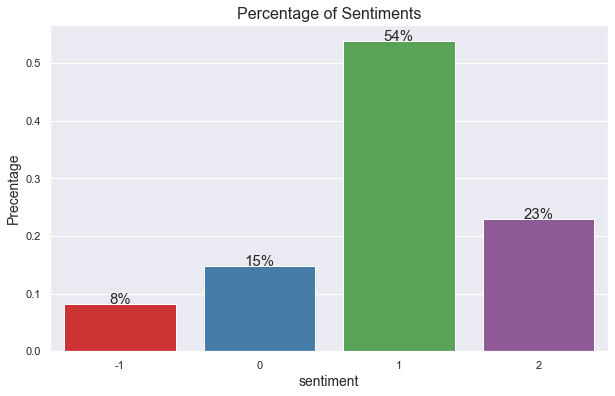

In [58]:
#How many data samples are provided for each sentiment
plt.figure(figsize=(10,6))
g = sns.barplot(train_set['sentiment'], train_set['sentiment'], palette='Set1', estimator=lambda x: len(x) / len(train_set))

for p in g.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    g.text(x+width/2, 
           y+height, 
           '{:.0%}'.format(height), 
           horizontalalignment='center',fontsize=15)
    
#Setting the labels
plt.xlabel('sentiment', fontsize=14)
plt.ylabel('Precentage', fontsize=14)
plt.title('Percentage of Sentiments', fontsize=16)

From the bar graph we can note that:
* Samples of sentiment 1 are the most while samples of sentiment -1 are the least in the dataset.
* 1 are pro climate change i.e the tweet supports the belief of man-made climate change
* -1 are anti climate change i.e the tweet does not believe in man-made climate change

When training a model, this will bring about class imbalance. This is where a model will be very good at predicting sentiments whose samples have more instances in the dataset than samples that have very few instances.

### Most common words per sentiment

In [59]:
# 10 most common words for the anti climate change sentiment
anti = train_set[train_set['sentiment']==-1]
collections.Counter(" ".join(anti["message"].str.lower()).split()).most_common(10)

[('the', 837),
 ('climate', 684),
 ('rt', 684),
 ('global', 585),
 ('is', 518),
 ('change', 476),
 ('to', 476),
 ('warming', 432),
 ('of', 349),
 ('a', 347)]

In [60]:
# 10 most common words for the neutral climate change sentiment
neutral = train_set[train_set['sentiment']==0]
collections.Counter(" ".join(neutral["message"].str.lower()).split()).most_common(10)

[('climate', 1370),
 ('rt', 1089),
 ('global', 1006),
 ('change', 940),
 ('the', 936),
 ('to', 745),
 ('warming', 691),
 ('is', 577),
 ('a', 560),
 ('of', 453)]

In [61]:
# 10 most common words for the pro climate change sentiment
pro = train_set[train_set['sentiment']==1]
collections.Counter(" ".join(pro["message"].str.lower()).split()).most_common(10)

[('climate', 7107),
 ('rt', 5787),
 ('change', 4884),
 ('the', 4682),
 ('to', 4299),
 ('is', 2802),
 ('a', 2662),
 ('of', 2597),
 ('in', 2386),
 ('and', 1847)]

In [62]:
# 10 most common words for the factual climate change sentiment
factual = train_set[train_set['sentiment']==2]
collections.Counter(" ".join(factual["message"].str.lower()).split()).most_common(10)

[('climate', 3162),
 ('change', 2583),
 ('rt', 2147),
 ('to', 1619),
 ('the', 1118),
 ('of', 795),
 ('on', 788),
 ('trump', 748),
 ('in', 588),
 ('a', 524)]

### Word Cloud

A word cloud will show the most common words before cleaning the data.

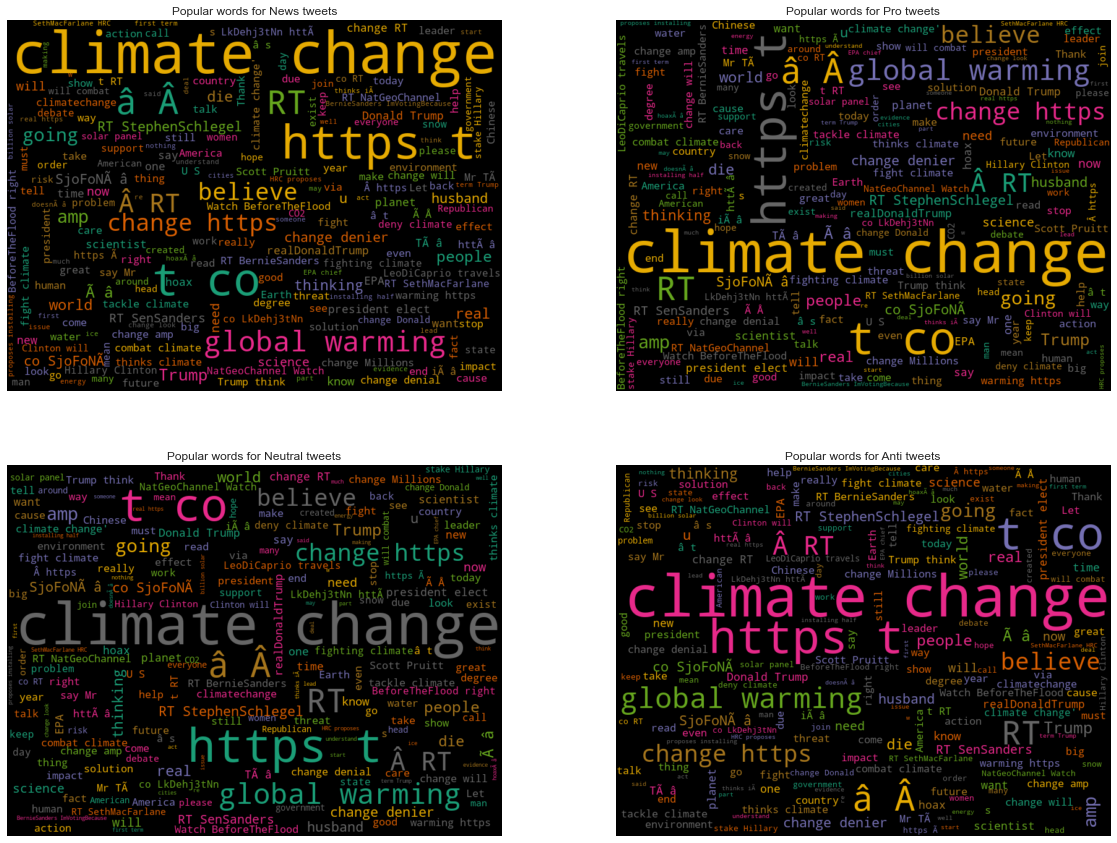

In [63]:
#Creating a Collection of written text of each sentiment class '''

news_tweets = ' '.join([text for text in train_set['message']
                        [train_set['sentiment'] == 2]])
pro_tweets = ' '.join([text for text in train_set['message']
                       [train_set['sentiment'] == 1]])
neutral_tweets = ' '.join([text for text in train_set['message']
                           [train_set['sentiment'] == 0]])
anti_tweets = ' '.join([text for text in train_set['message']
                        [train_set['sentiment'] == -1]])

# Visualising sentiment class 
full_title = ['Popular words for News tweets',
              'Popular words for Pro tweets',
              'Popular words for Neutral tweets',
              'Popular words for Anti tweets']

tweet_list = [news_tweets, pro_tweets,
              neutral_tweets, anti_tweets]

# Create word clouds of the most common words in each sentiment class
wc = WordCloud(width=800, height=600, 
               background_color='black', colormap='Dark2',
               max_font_size=150, random_state=42)

plt.rcParams['figure.figsize'] = [20, 15]

# Create subplots 
for i in range(0, len(tweet_list)):
    wc.generate(tweet_list[1])
    
    plt.subplot(2, 2, i + 1)
    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    plt.title(full_title[i])
    
plt.show()

From the word cloud we can note that:
* There are a lot or url links in the text (https)
* Frequently used specific words RELEVANT to climate change are: climate, global, warming, change, EPA( United States Environmental Protection Agency), dioxide, CO (carbon monoxide), mashable(a news network), think, cause, change, evidence 

# Feature Engineering
This involves:
* Class balancing
* Noise removal
* Normalization

In [64]:
#class imbalance
print(train_set['sentiment'].value_counts())


 1    8530
 2    3640
 0    2353
-1    1296
Name: sentiment, dtype: int64


In [65]:
#seperate the sentiments
df_pro= train_set[train_set['sentiment']==1]
df_factual= train_set[train_set['sentiment']==2]
df_neutral= train_set[train_set['sentiment']==0]
df_anti= train_set[train_set['sentiment']== -1]

#upsample minority class seperately
df_anti_upsampled= resample(df_anti,
                            replace=True,
                            n_samples=4265,
                            random_state=42
                            )
df_neutral_upsampled= resample(df_neutral,
                            replace=True,
                            n_samples=4265,
                            random_state=42
                            )
df_factual_upsampled= resample(df_factual,
                            replace=True,
                            n_samples=4265,
                            random_state=42
                            )

#downsample majority class
df_pro_downsampled = resample(df_pro,
                              replace=False,
                              n_samples= 4265,
                              random_state=42
                             )

#combine the dataframes
#train_set_balanced= pd.concat([df_pro, df_factual, df_neutral, df_anti])
train_set_balanced= pd.concat([df_pro_downsampled, df_factual_upsampled, df_neutral_upsampled, df_anti_upsampled])
print (train_set_balanced['sentiment'].value_counts())

 0    4265
 1    4265
 2    4265
-1    4265
Name: sentiment, dtype: int64


Noise removal involves removing any piece of information that is not relevant. To remove noise from the tweets, we are going to:
* Remove urls 
* Remove twitter handles (e.g @name) - done by TweetTokenizer
* Remove retweet marks (RT) 
* Remove single numeric terms
* Remove punctuation

In [66]:
#remove noise: words that do not add any information
def remove_noise(df, column_name):
    
    #weird characters
    weird = r'[Ã°Å¸Ëœâ€¢â‚¬Â¦…’]'
    df[column_name] = df[column_name].replace(to_replace = weird, value = '', regex = True)
    
    #remove retweet marks (RT)
    rt_marks = r'RT+' 
    df[column_name] = df[column_name].replace(to_replace = rt_marks, value = '', regex = True)
    
    #replace urls with http
    url_pattern =r'http[s]?://(?:[A-Za-z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9A-Fa-f][0-9A-Fa-f]))+'
    df[column_name] = df[column_name].replace(to_replace = url_pattern, value = 'https', regex = True)
    
    #remove single numeric terms
    numeric_terms = r'[0-9]' 
    df[column_name] = df[column_name].replace(to_replace = numeric_terms, value = '', regex = True) 
    
    return df
     

In [67]:
remove_noise(train_set_balanced, 'message')

,sentiment,message,tweetid
4722,1,"@NatGeoChannel: Watch #BeforeTheFlood right here, as @LeoDiCaprio travels the world to tackle climate change https htt",555359
14904,1,@SenSanders: We have a president-elect who doesn't believe in climate change. Millions of people are going to have to say: Mr. T,504402
12635,1,@OCTorg: Fed court has ruled rights of @octorg youth threatened by climate change. Help them proceed to trial!,559217
11307,1,@Aiannucci: The US elected Trump but the rest of the world didn't.So what do we do if US policies ( e.g. climate change) threaten the re,936602
12348,1,@SenSanders: We have a president-elect who doesn„t believe in climate change. That„s frightening for this country and the world.,639182
...,...,...,...
10980,-1,@democracynow @SenWhitehouse Anthropogenic climate change is the greatest lie ever perpetuated in modern human history.,901823
14983,-1,"@PolitixGal: Over past decade, global temps hv not increased; global warming has ceased &amp; signs of future deep temp drop. https",849994
732,-1,@RealJamesWoods: Do penises cause climate change? Discuss | The Spectator // I need not comment on this one... #liberals https,33000
4445,-1,"@goddersbloom: Man made apocryphal climate change, is it the longest running State sponsored scientific scam in the history of man",310077


In [68]:
#remove punctuation
def remove_punctuation(post):
    return ''.join([l for l in post if l not in string.punctuation])

train_set_balanced['message'] = train_set_balanced['message'].apply(remove_punctuation)
train_set_balanced['message'].iloc[1000]

' MarkRuffalo Existential threat US needs to accelerate growth in green jobs by treating climate change like the crisis of WWII https'

### Word normalization
We are going to:
* Tokenize the text (use TweetTokenizer)
* Remove stopwords
* Perform stemming 
* Perform lammetization 
* Convert all text to lowercase
* Create features out of the text (use CountVectorize or TIF-ID)

In [69]:
#word normalization
def normalize_words(df, column_name):
    #convert words to lowercase
    df[column_name] = df[column_name].str.lower()
    
    #tokenization
    tokeniser = TweetTokenizer()
    df['tokens'] = df[column_name].apply(tokeniser.tokenize)
    
    return df  

In [70]:
normalize_words(train_set_balanced, 'message')

,sentiment,message,tweetid,tokens
4722,1,natgeochannel watch beforetheflood right here as leodicaprio travels the world to tackle climate change https htt,555359,"[natgeochannel, watch, beforetheflood, right, here, as, leodicaprio, travels, the, world, to, tackle, climate, change, https, htt]"
14904,1,sensanders we have a presidentelect who doesnt believe in climate change millions of people are going to have to say mr t,504402,"[sensanders, we, have, a, presidentelect, who, doesnt, believe, in, climate, change, millions, of, people, are, going, to, have, to, say, mr, t]"
12635,1,octorg fed court has ruled rights of octorg youth threatened by climate change help them proceed to trial,559217,"[octorg, fed, court, has, ruled, rights, of, octorg, youth, threatened, by, climate, change, help, them, proceed, to, trial]"
11307,1,aiannucci the us elected trump but the rest of the world didntso what do we do if us policies eg climate change threaten the re,936602,"[aiannucci, the, us, elected, trump, but, the, rest, of, the, world, didntso, what, do, we, do, if, us, policies, eg, climate, change, threaten, the, re]"
12348,1,sensanders we have a presidentelect who doesn„t believe in climate change that„s frightening for this country and the world,639182,"[sensanders, we, have, a, presidentelect, who, doesn, „, t, believe, in, climate, change, that, „, s, frightening, for, this, country, and, the, world]"
...,...,...,...,...
10980,-1,democracynow senwhitehouse anthropogenic climate change is the greatest lie ever perpetuated in modern human history,901823,"[democracynow, senwhitehouse, anthropogenic, climate, change, is, the, greatest, lie, ever, perpetuated, in, modern, human, history]"
14983,-1,politixgal over past decade global temps hv not increased global warming has ceased amp signs of future deep temp drop https,849994,"[politixgal, over, past, decade, global, temps, hv, not, increased, global, warming, has, ceased, amp, signs, of, future, deep, temp, drop, https]"
732,-1,realjameswoods do penises cause climate change discuss the spectator i need not comment on this one liberals https,33000,"[realjameswoods, do, penises, cause, climate, change, discuss, the, spectator, i, need, not, comment, on, this, one, liberals, https]"
4445,-1,goddersbloom man made apocryphal climate change is it the longest running state sponsored scientific scam in the history of man,310077,"[goddersbloom, man, made, apocryphal, climate, change, is, it, the, longest, running, state, sponsored, scientific, scam, in, the, history, of, man]"


In [71]:
def remove_stop_words(tokens):    
    return [t for t in tokens if t not in stopwords.words('english')]

In [72]:
train_set_balanced['new_tokens'] = train_set_balanced['tokens'].apply(remove_stop_words)

In [73]:
train_set_balanced.head()

,sentiment,message,tweetid,tokens,new_tokens
4722,1,natgeochannel watch beforetheflood right here as leodicaprio travels the world to tackle climate change https htt,555359,"[natgeochannel, watch, beforetheflood, right, here, as, leodicaprio, travels, the, world, to, tackle, climate, change, https, htt]","[natgeochannel, watch, beforetheflood, right, leodicaprio, travels, world, tackle, climate, change, https, htt]"
14904,1,sensanders we have a presidentelect who doesnt believe in climate change millions of people are going to have to say mr t,504402,"[sensanders, we, have, a, presidentelect, who, doesnt, believe, in, climate, change, millions, of, people, are, going, to, have, to, say, mr, t]","[sensanders, presidentelect, doesnt, believe, climate, change, millions, people, going, say, mr]"
12635,1,octorg fed court has ruled rights of octorg youth threatened by climate change help them proceed to trial,559217,"[octorg, fed, court, has, ruled, rights, of, octorg, youth, threatened, by, climate, change, help, them, proceed, to, trial]","[octorg, fed, court, ruled, rights, octorg, youth, threatened, climate, change, help, proceed, trial]"
11307,1,aiannucci the us elected trump but the rest of the world didntso what do we do if us policies eg climate change threaten the re,936602,"[aiannucci, the, us, elected, trump, but, the, rest, of, the, world, didntso, what, do, we, do, if, us, policies, eg, climate, change, threaten, the, re]","[aiannucci, us, elected, trump, rest, world, didntso, us, policies, eg, climate, change, threaten]"
12348,1,sensanders we have a presidentelect who doesn„t believe in climate change that„s frightening for this country and the world,639182,"[sensanders, we, have, a, presidentelect, who, doesn, „, t, believe, in, climate, change, that, „, s, frightening, for, this, country, and, the, world]","[sensanders, presidentelect, „, believe, climate, change, „, frightening, country, world]"


Note from the above dataframe that the TweetTokenizer has also removed the twitter handles (@) and the hashtag(#) only without removing the word that comes after these symbols. This could be useful because some handles especially those of public figures are connected to certain sentiments, e.g @donaldtrump.

In [74]:
#stemming
stemmer = SnowballStemmer('english')
def train_stemmer(words, stemmer):
    return [stemmer.stem(word) for word in words]

In [75]:
train_set_balanced['stem'] = train_set_balanced['new_tokens'].apply(train_stemmer, args=(stemmer, ))
train_set_balanced.head()

,sentiment,message,tweetid,tokens,new_tokens,stem
4722,1,natgeochannel watch beforetheflood right here as leodicaprio travels the world to tackle climate change https htt,555359,"[natgeochannel, watch, beforetheflood, right, here, as, leodicaprio, travels, the, world, to, tackle, climate, change, https, htt]","[natgeochannel, watch, beforetheflood, right, leodicaprio, travels, world, tackle, climate, change, https, htt]","[natgeochannel, watch, beforetheflood, right, leodicaprio, travel, world, tackl, climat, chang, https, htt]"
14904,1,sensanders we have a presidentelect who doesnt believe in climate change millions of people are going to have to say mr t,504402,"[sensanders, we, have, a, presidentelect, who, doesnt, believe, in, climate, change, millions, of, people, are, going, to, have, to, say, mr, t]","[sensanders, presidentelect, doesnt, believe, climate, change, millions, people, going, say, mr]","[sensand, presidentelect, doesnt, believ, climat, chang, million, peopl, go, say, mr]"
12635,1,octorg fed court has ruled rights of octorg youth threatened by climate change help them proceed to trial,559217,"[octorg, fed, court, has, ruled, rights, of, octorg, youth, threatened, by, climate, change, help, them, proceed, to, trial]","[octorg, fed, court, ruled, rights, octorg, youth, threatened, climate, change, help, proceed, trial]","[octorg, fed, court, rule, right, octorg, youth, threaten, climat, chang, help, proceed, trial]"
11307,1,aiannucci the us elected trump but the rest of the world didntso what do we do if us policies eg climate change threaten the re,936602,"[aiannucci, the, us, elected, trump, but, the, rest, of, the, world, didntso, what, do, we, do, if, us, policies, eg, climate, change, threaten, the, re]","[aiannucci, us, elected, trump, rest, world, didntso, us, policies, eg, climate, change, threaten]","[aiannucci, us, elect, trump, rest, world, didntso, us, polici, eg, climat, chang, threaten]"
12348,1,sensanders we have a presidentelect who doesn„t believe in climate change that„s frightening for this country and the world,639182,"[sensanders, we, have, a, presidentelect, who, doesn, „, t, believe, in, climate, change, that, „, s, frightening, for, this, country, and, the, world]","[sensanders, presidentelect, „, believe, climate, change, „, frightening, country, world]","[sensand, presidentelect, „, believ, climat, chang, „, frighten, countri, world]"


In [76]:
#lammetization
lemmatizer = WordNetLemmatizer()

def train_lemma(words, lemmatizer):
    return [lemmatizer.lemmatize(word) for word in words]
    

In [77]:
train_set_balanced['lemma'] = train_set_balanced['stem'].apply(train_lemma, args=(lemmatizer, ))
train_set_balanced.head()

,sentiment,message,tweetid,tokens,new_tokens,stem,lemma
4722,1,natgeochannel watch beforetheflood right here as leodicaprio travels the world to tackle climate change https htt,555359,"[natgeochannel, watch, beforetheflood, right, here, as, leodicaprio, travels, the, world, to, tackle, climate, change, https, htt]","[natgeochannel, watch, beforetheflood, right, leodicaprio, travels, world, tackle, climate, change, https, htt]","[natgeochannel, watch, beforetheflood, right, leodicaprio, travel, world, tackl, climat, chang, https, htt]","[natgeochannel, watch, beforetheflood, right, leodicaprio, travel, world, tackl, climat, chang, http, htt]"
14904,1,sensanders we have a presidentelect who doesnt believe in climate change millions of people are going to have to say mr t,504402,"[sensanders, we, have, a, presidentelect, who, doesnt, believe, in, climate, change, millions, of, people, are, going, to, have, to, say, mr, t]","[sensanders, presidentelect, doesnt, believe, climate, change, millions, people, going, say, mr]","[sensand, presidentelect, doesnt, believ, climat, chang, million, peopl, go, say, mr]","[sensand, presidentelect, doesnt, believ, climat, chang, million, peopl, go, say, mr]"
12635,1,octorg fed court has ruled rights of octorg youth threatened by climate change help them proceed to trial,559217,"[octorg, fed, court, has, ruled, rights, of, octorg, youth, threatened, by, climate, change, help, them, proceed, to, trial]","[octorg, fed, court, ruled, rights, octorg, youth, threatened, climate, change, help, proceed, trial]","[octorg, fed, court, rule, right, octorg, youth, threaten, climat, chang, help, proceed, trial]","[octorg, fed, court, rule, right, octorg, youth, threaten, climat, chang, help, proceed, trial]"
11307,1,aiannucci the us elected trump but the rest of the world didntso what do we do if us policies eg climate change threaten the re,936602,"[aiannucci, the, us, elected, trump, but, the, rest, of, the, world, didntso, what, do, we, do, if, us, policies, eg, climate, change, threaten, the, re]","[aiannucci, us, elected, trump, rest, world, didntso, us, policies, eg, climate, change, threaten]","[aiannucci, us, elect, trump, rest, world, didntso, us, polici, eg, climat, chang, threaten]","[aiannucci, u, elect, trump, rest, world, didntso, u, polici, eg, climat, chang, threaten]"
12348,1,sensanders we have a presidentelect who doesn„t believe in climate change that„s frightening for this country and the world,639182,"[sensanders, we, have, a, presidentelect, who, doesn, „, t, believe, in, climate, change, that, „, s, frightening, for, this, country, and, the, world]","[sensanders, presidentelect, „, believe, climate, change, „, frightening, country, world]","[sensand, presidentelect, „, believ, climat, chang, „, frighten, countri, world]","[sensand, presidentelect, „, believ, climat, chang, „, frighten, countri, world]"


#### Most common words after preprocessing 

In [78]:
#join the words to make a string and extract the most common words
train_set_balanced['clean_message'] = train_set_balanced.lemma.apply(lambda x: ' '.join ([str(i) for i in x]))
train_set_balanced.head()


,sentiment,message,tweetid,tokens,new_tokens,stem,lemma,clean_message
4722,1,natgeochannel watch beforetheflood right here as leodicaprio travels the world to tackle climate change https htt,555359,"[natgeochannel, watch, beforetheflood, right, here, as, leodicaprio, travels, the, world, to, tackle, climate, change, https, htt]","[natgeochannel, watch, beforetheflood, right, leodicaprio, travels, world, tackle, climate, change, https, htt]","[natgeochannel, watch, beforetheflood, right, leodicaprio, travel, world, tackl, climat, chang, https, htt]","[natgeochannel, watch, beforetheflood, right, leodicaprio, travel, world, tackl, climat, chang, http, htt]",natgeochannel watch beforetheflood right leodicaprio travel world tackl climat chang http htt
14904,1,sensanders we have a presidentelect who doesnt believe in climate change millions of people are going to have to say mr t,504402,"[sensanders, we, have, a, presidentelect, who, doesnt, believe, in, climate, change, millions, of, people, are, going, to, have, to, say, mr, t]","[sensanders, presidentelect, doesnt, believe, climate, change, millions, people, going, say, mr]","[sensand, presidentelect, doesnt, believ, climat, chang, million, peopl, go, say, mr]","[sensand, presidentelect, doesnt, believ, climat, chang, million, peopl, go, say, mr]",sensand presidentelect doesnt believ climat chang million peopl go say mr
12635,1,octorg fed court has ruled rights of octorg youth threatened by climate change help them proceed to trial,559217,"[octorg, fed, court, has, ruled, rights, of, octorg, youth, threatened, by, climate, change, help, them, proceed, to, trial]","[octorg, fed, court, ruled, rights, octorg, youth, threatened, climate, change, help, proceed, trial]","[octorg, fed, court, rule, right, octorg, youth, threaten, climat, chang, help, proceed, trial]","[octorg, fed, court, rule, right, octorg, youth, threaten, climat, chang, help, proceed, trial]",octorg fed court rule right octorg youth threaten climat chang help proceed trial
11307,1,aiannucci the us elected trump but the rest of the world didntso what do we do if us policies eg climate change threaten the re,936602,"[aiannucci, the, us, elected, trump, but, the, rest, of, the, world, didntso, what, do, we, do, if, us, policies, eg, climate, change, threaten, the, re]","[aiannucci, us, elected, trump, rest, world, didntso, us, policies, eg, climate, change, threaten]","[aiannucci, us, elect, trump, rest, world, didntso, us, polici, eg, climat, chang, threaten]","[aiannucci, u, elect, trump, rest, world, didntso, u, polici, eg, climat, chang, threaten]",aiannucci u elect trump rest world didntso u polici eg climat chang threaten
12348,1,sensanders we have a presidentelect who doesn„t believe in climate change that„s frightening for this country and the world,639182,"[sensanders, we, have, a, presidentelect, who, doesn, „, t, believe, in, climate, change, that, „, s, frightening, for, this, country, and, the, world]","[sensanders, presidentelect, „, believe, climate, change, „, frightening, country, world]","[sensand, presidentelect, „, believ, climat, chang, „, frighten, countri, world]","[sensand, presidentelect, „, believ, climat, chang, „, frighten, countri, world]",sensand presidentelect „ believ climat chang „ frighten countri world


In [79]:
#Anti climate change. Does not believe in climate change.
anti = train_set_balanced[train_set_balanced['sentiment']==-1]
collections.Counter(" ".join(anti["clean_message"].str.lower()).split()).most_common(10)

[('climat', 2617),
 ('chang', 2512),
 ('global', 2138),
 ('warm', 2056),
 ('http', 1885),
 ('scienc', 251),
 ('caus', 248),
 ('amp', 247),
 ('realdonaldtrump', 242),
 ('u', 229)]

In [80]:
# neutral
neutral = train_set_balanced[train_set_balanced['sentiment']==0]
collections.Counter(" ".join(neutral["clean_message"].str.lower()).split()).most_common(10)

[('climat', 2613),
 ('chang', 2545),
 ('global', 1894),
 ('warm', 1856),
 ('http', 1691),
 ('trump', 331),
 ('�', 245),
 ('u', 237),
 ('like', 218),
 ('believ', 207)]

In [81]:
#pro climate change
pro = train_set_balanced[train_set_balanced['sentiment']==1]
collections.Counter(" ".join(pro["clean_message"].str.lower()).split()).most_common(10)

[('climat', 3690),
 ('chang', 3605),
 ('http', 2252),
 ('global', 806),
 ('warm', 749),
 ('believ', 550),
 ('trump', 549),
 ('think', 408),
 ('doesnt', 358),
 ('amp', 346)]

In [82]:
#factual
factual = train_set_balanced[train_set_balanced['sentiment']==2]
collections.Counter(" ".join(factual["clean_message"].str.lower()).split()).most_common(10)

[('http', 4876),
 ('climat', 3938),
 ('chang', 3835),
 ('trump', 1231),
 ('global', 604),
 ('warm', 514),
 ('u', 382),
 ('say', 357),
 ('via', 353),
 ('epa', 289)]

### Vectorization 
Here we convert the text into values.
To do this we can use:
* CountVectorizer

In [83]:
# vectorization
vect = CountVectorizer(min_df=2, 
                      max_df=0.5,
                       #max_features= 1000,
                             ngram_range=(1, 2))
#fit and transorm data 
training_x = vect.fit_transform(train_set_balanced['clean_message']) 

To select the most important features we can use:
* Select K-best

In [84]:
#define features and variables
X = training_x 
y = train_set_balanced['sentiment']

#split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=50)

In [85]:
# Set up selector, choosing score function and number of features to retain
selector_kbest = feature_selection.SelectKBest(score_func=f_classif, k=8700)

# Transform (i.e.: run selection on) the training data
X_train_kbest = selector_kbest.fit_transform(X_train, y_train)

import warnings
warnings.filterwarnings("ignore")

In [86]:
X_train_kbest.shape

(13648, 8700)

In [87]:
# transform the test data the same way we did the train data
X_test_kbest = selector_kbest.transform(X_test)

X_test_kbest.shape

(3412, 8700)

## Modelling 

We will build multiple models at once and determine which model is fast and good at predicting the sentiment. We will then pick the best model based on:
* The time it takes 
* The accuracy of the predictions

The models we wil test are:
* Logistic Resgression
* KNN
* SVM (linear and rbf)
* Decision Tree
* Random Forest 
* Adaboost

In [360]:
names = ['Logistic Regression', 'Nearest Neighbors', 
         'Linear SVM', 'RBF SVM',          
         'Decision Tree', 'Random Forest',  'AdaBoost']
 
classifiers = [LogisticRegression(multi_class='ovr', class_weight='balanced'), 
               KNeighborsClassifier(3),
               SVC(kernel="linear", C=0.025),
               SVC(gamma=2, C=1),
               DecisionTreeClassifier(max_depth=5),
               RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),    
               AdaBoostClassifier()
              ]

In [361]:
results = []

models = {}
confusion = {}
class_report = {}


for name, clf in zip(names, classifiers):    
    print ('Fitting {:s} model...'.format(name))
    run_time = %timeit -q -o clf.fit(X_train, y_train)
    
    print ('... predicting')
    y_pred = clf.predict(X_train)   
    y_pred_test = clf.predict(X_test)
    
    print ('... scoring')
    accuracy  = metrics.accuracy_score(y_train, y_pred)
    precision = metrics.precision_score(y_train, y_pred, average = 'micro')
    recall    = metrics.recall_score(y_train, y_pred, average = 'micro')
    
    f1        = metrics.f1_score(y_train, y_pred, average = 'micro')    
    f1_test   = metrics.f1_score(y_test, y_pred_test, average = 'micro')    
    
    # Save the results to dictionaries
    models[name] = clf    
    confusion[name] = metrics.confusion_matrix(y_train, y_pred)
    class_report[name] = metrics.classification_report(y_train, y_pred)
    
    results.append([name, accuracy, precision, recall, f1, f1_test, run_time.best])

    
results = pd.DataFrame(results, columns=['Classifier', 'Accuracy', 'Precision', 'Recall', 'F1 Train', 'F1 Test', 'Train Time'])
results.set_index('Classifier', inplace= True)

print ('... All done!')

Fitting Logistic Regression model...
... predicting
... scoring
Fitting Nearest Neighbors model...
... predicting
... scoring
Fitting Linear SVM model...
... predicting
... scoring
Fitting RBF SVM model...
... predicting
... scoring
Fitting Decision Tree model...
... predicting
... scoring
Fitting Random Forest model...
... predicting
... scoring
Fitting AdaBoost model...
... predicting
... scoring
... All done!


In [362]:
results.sort_values('F1 Train', ascending=False)

,Accuracy,Precision,Recall,F1 Train,F1 Test,Train Time
Classifier,,,,,,
RBF SVM,0.982552,0.982552,0.982552,0.982552,0.951366,113.810700
Logistic Regression,0.969035,0.969035,0.969035,0.969035,0.928592,2.569402
Nearest Neighbors,0.960292,0.960292,0.960292,0.960292,0.905378,0.003619
Linear SVM,0.511460,0.511460,0.511460,0.511460,0.474434,96.964311
AdaBoost,0.358617,0.358617,0.358617,0.358617,0.360270,13.934279
Decision Tree,0.280782,0.280782,0.280782,0.280782,0.284896,0.322343
Random Forest,0.260175,0.260175,0.260175,0.260175,0.252718,0.063115


### 1. Support Vector Machine(RBF)

This is a support vector machine that enables the model to fit a non-linear decision boundary.

In [ ]:
parameters = {'kernel':('linear','rbf'), 
              'C':(0.25,1.0),
              'gamma': (1,2)
             }

svm = SVC()
clf = GridSearchCV(svm, parameters)
clf.fit(X_train_kbest,y_train)

In [ ]:
clf.best_params_

In [364]:
# Before generating predictions, we'll need to transform the test data the same way we did the train data
#X_test_kbest = selector_kbest.transform(X_test)

#predict
svm_y_pred = clf.predict(X_test_kbest)

#variance threshold
# Now we'll need to remove the same features we did in the thresholding process
#X_test_vt = selector.transform(X_test)

# Generate predictions from var thresh model
#vt_y_pred = svm.predict(X_test_vt)

In [365]:
# Classification report
svm_score = classification_report(y_test,svm_y_pred)
print(svm_score)

import warnings
warnings.filterwarnings('ignore')

              precision    recall  f1-score   support

          -1       0.98      0.91      0.94      1691
           0       0.96      0.63      0.76      1723
           1       0.54      0.89      0.67      1665
           2       0.90      0.69      0.78      1727

    accuracy                           0.78      6806
   macro avg       0.84      0.78      0.79      6806
weighted avg       0.85      0.78      0.79      6806



### 2. Logistic Regression

In [47]:
#define features and variables
#X = cv_train_df
#y = train_set['sentiment']

#split data
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=50)

logreg = LogisticRegression(multi_class='ovr')#, class_weight='balanced')

logreg.fit(X_train_kbest, y_train)

LogisticRegression(multi_class='ovr')

In [48]:
#Generate predictions
y_pred_test = logreg.predict(X_test_kbest)

In [49]:
#metrics
#log_accuracy  = metrics.accuracy_score(y_train, y_pred_test)
#log_precision = metrics.precision_score(y_train, y_pred_test, average = 'micro')
#log_recall    = metrics.recall_score(y_train, y_pred_test, average = 'micro')
    
#log_f1        = metrics.f1_score(y_train, y_pred_test, average = 'micro')    
#log_f1_test   = metrics.f1_score(y_test, y_pred_test, average = 'micro')    
    
# Classification report
score = classification_report(y_test, y_pred_test)
print(score)

import warnings
warnings.filterwarnings('ignore')

              precision    recall  f1-score   support

          -1       0.90      0.83      0.87       850
           0       0.72      0.79      0.76       837
           1       0.71      0.67      0.69       861
           2       0.80      0.83      0.82       864

    accuracy                           0.78      3412
   macro avg       0.78      0.78      0.78      3412
weighted avg       0.78      0.78      0.78      3412



In [50]:
#confusion matrix 
confusion_matrix(y_test, y_pred_test)

array([[707,  70,  55,  18],
       [ 28, 665,  95,  49],
       [ 41, 134, 578, 108],
       [  8,  54,  84, 718]], dtype=int64)

### 3. Naive Bayes

In [328]:
#define parameters
params = {'alpha': [0.01, 0.1, 0.5, 1.0, 10.0, ],
         }

#perform a grid search to obtain the best alpha
multinomial_nb_grid = GridSearchCV(MultinomialNB(), param_grid=params, n_jobs=-1, cv=5, verbose=5)
multinomial_nb_grid.fit(X_train_kbest, y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


GridSearchCV(cv=5, estimator=MultinomialNB(), n_jobs=-1,
             param_grid={'alpha': [0.01, 0.1, 0.5, 1.0, 10.0]}, verbose=5)

In [330]:
# print out the accuracy and best parameters of the model
print('Train Accuracy : %.3f'%multinomial_nb_grid.best_estimator_.score(X_train_kbest, y_train))
print('Test Accuracy : %.3f'%multinomial_nb_grid.best_estimator_.score(X_test_kbest, y_test))
print('Best Accuracy Through Grid Search : %.3f'%multinomial_nb_grid.best_score_)
print('Best Parameters : ',multinomial_nb_grid.best_params_)

Train Accuracy : 0.887
Test Accuracy : 0.808
Best Accuracy Through Grid Search : 0.860
Best Parameters :  {'alpha': 0.01}


In [331]:
# instatiate the best model from the best parameters defined above
naive_bayes= MultinomialNB(alpha=0.01)
naive_bayes.fit(X_train_kbest, y_train)

MultinomialNB(alpha=0.01)

In [332]:
#generate predictions
nb_tuned_pred = naive_bayes.predict(X_test_kbest)

In [333]:
# assess accuracy using the classification report
nb_report = classification_report(y_test,nb_tuned_pred)
print(nb_report)

              precision    recall  f1-score   support

          -1       0.93      0.93      0.93      1691
           0       0.89      0.65      0.75      1723
           1       0.63      0.82      0.71      1665
           2       0.86      0.83      0.85      1727

    accuracy                           0.81      6806
   macro avg       0.83      0.81      0.81      6806
weighted avg       0.83      0.81      0.81      6806



### 4.Random Forest Model

In [334]:
# instantiate and train the random forest classifier
RF = RandomForestClassifier()
RF.fit(X_train_kbest, y_train)
RF_pred = RF.predict(X_test_kbest)

In [335]:
# assess accuracy using the classification report
rf_report = classification_report(y_test,RF_pred)
print(rf_report)

              precision    recall  f1-score   support

          -1       0.99      1.00      0.99      1691
           0       0.90      0.98      0.94      1723
           1       0.94      0.80      0.87      1665
           2       0.90      0.95      0.92      1727

    accuracy                           0.93      6806
   macro avg       0.93      0.93      0.93      6806
weighted avg       0.93      0.93      0.93      6806



### Log metrics on Comet

In [51]:
# Create dictionaries for the data we want to log

params = {"random_state": 50,
          "model_type": "logreg"
          }

metrics = {'all_metrics': score}

experiment.log_parameters(params)
experiment.log_metrics(metrics)

In [54]:
experiment.end()

COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.ml/sholaog/edsa/4d756e7d3c0047f09ddba8e141520382
COMET INFO:   Uploads:
COMET INFO:     conda-environment-definition : 1
COMET INFO:     conda-info                   : 1
COMET INFO:     conda-specification          : 1
COMET INFO:     environment details          : 1
COMET INFO:     filename                     : 1
COMET INFO:     installed packages           : 1
COMET INFO:     notebook                     : 1
COMET INFO:     source_code                  : 1
COMET INFO: ---------------------------
COMET WARNING: Comet has disabled auto-logging functionality as it has been imported after the following ML modules: sklearn. Metrics and hyperparameters can still be logged using comet_ml.log_metrics() and comet_ml.log_parameters()
COMET INFO: Uploading m

## Model Performance 

Here we apply the random forest to the test set with no labels since it gave us the best score on accuracy. 

In [55]:
#load test set data
df_test = pd.read_csv('test_with_no_labels.csv')

test_set = df_test.copy()

pd.set_option('max_colwidth', None)
test_set.head()

,message,tweetid
0,Europe will now be looking to China to make sure that it is not alone in fighting climate change… https://t.co/O7T8rCgwDq,169760
1,Combine this with the polling of staffers re climate change and womens' rights and you have a fascist state. https://t.co/ifrm7eexpj,35326
2,"The scary, unimpeachable evidence that climate change is already here: https://t.co/yAedqcV9Ki #itstimetochange #climatechange @ZEROCO2_;..",224985
3,@Karoli @morgfair @OsborneInk @dailykos \nPutin got to you too Jill ! \nTrump doesn't believe in climate change at all \nThinks it's s hoax,476263
4,RT @FakeWillMoore: 'Female orgasms cause global warming!'\n-Sarcastic Republican,872928


Preprocess the data like we did with the train set. 
This means that we apply the folowing predefined functions:
* remove_noise(df, column_name)
* remove_punctuation(post)
* normalize_words(df, column_name)
* train_lemma(words, lemmatizer)
* Vecorize using CountVectorizer

In [153]:
remove_noise(test_set, 'message')

,message,tweetid
0,Europe will now be looking to China to make sure that it is not alone in fighting climate change https,169760
1,Combine this with the polling of staffers re climate change and womens' rights and you have a fascist state. https,35326
2,"The scary, unimpeachable evidence that climate change is already here: https #itstimetochange #climatechange @ZEROCO_;..",224985
3,@Karoli @morgfair @OsborneInk @dailykos \nPutin got to you too Jill ! \nTrump doesn't believe in climate change at all \nThinks it's s hoax,476263
4,@FakeWillMoore: 'Female orgasms cause global warming!'\n-Sarcastic Republican,872928
...,...,...
10541,"@BrittanyBohrer: Brb, writing a poem about climate change. #climatechange #science #poetry #fakenews #alternativefacts https",895714
10542,": the year climate change came home: During the hottest year on record, Karl Mathiesen travelled to Tasmania https",875167
10543,@loop_vanuatu: Pacific countries positive about Fiji leading the global climate change conference in November. https,78329
10544,"@xanria_: Youre so hot, you must be the cause for global warming. #ALDUBLaborOfLove @jophie @asn",867455


In [154]:
test_set['message'] = test_set['message'].apply(remove_punctuation)

In [155]:
normalize_words(test_set, 'message')

,message,tweetid,tokens
0,europe will now be looking to china to make sure that it is not alone in fighting climate change https,169760,"[europe, will, now, be, looking, to, china, to, make, sure, that, it, is, not, alone, in, fighting, climate, change, https]"
1,combine this with the polling of staffers re climate change and womens rights and you have a fascist state https,35326,"[combine, this, with, the, polling, of, staffers, re, climate, change, and, womens, rights, and, you, have, a, fascist, state, https]"
2,the scary unimpeachable evidence that climate change is already here https itstimetochange climatechange zeroco,224985,"[the, scary, unimpeachable, evidence, that, climate, change, is, already, here, https, itstimetochange, climatechange, zeroco]"
3,karoli morgfair osborneink dailykos \nputin got to you too jill \ntrump doesnt believe in climate change at all \nthinks its s hoax,476263,"[karoli, morgfair, osborneink, dailykos, putin, got, to, you, too, jill, trump, doesnt, believe, in, climate, change, at, all, thinks, its, s, hoax]"
4,fakewillmoore female orgasms cause global warming\nsarcastic republican,872928,"[fakewillmoore, female, orgasms, cause, global, warming, sarcastic, republican]"
...,...,...,...
10541,brittanybohrer brb writing a poem about climate change climatechange science poetry fakenews alternativefacts https,895714,"[brittanybohrer, brb, writing, a, poem, about, climate, change, climatechange, science, poetry, fakenews, alternativefacts, https]"
10542,the year climate change came home during the hottest year on record karl mathiesen travelled to tasmania https,875167,"[the, year, climate, change, came, home, during, the, hottest, year, on, record, karl, mathiesen, travelled, to, tasmania, https]"
10543,loopvanuatu pacific countries positive about fiji leading the global climate change conference in november https,78329,"[loopvanuatu, pacific, countries, positive, about, fiji, leading, the, global, climate, change, conference, in, november, https]"
10544,xanria youre so hot you must be the cause for global warming aldublaboroflove jophie asn,867455,"[xanria, youre, so, hot, you, must, be, the, cause, for, global, warming, aldublaboroflove, jophie, asn]"


In [156]:
test_set['new_tokens'] = test_set['tokens'].apply(remove_stop_words)

In [157]:
test_set['stem'] = test_set['new_tokens'].apply(train_stemmer, args=(stemmer, ))
test_set.head()

,message,tweetid,tokens,new_tokens,stem
0,europe will now be looking to china to make sure that it is not alone in fighting climate change https,169760,"[europe, will, now, be, looking, to, china, to, make, sure, that, it, is, not, alone, in, fighting, climate, change, https]","[europe, looking, china, make, sure, alone, fighting, climate, change, https]","[europ, look, china, make, sure, alon, fight, climat, chang, https]"
1,combine this with the polling of staffers re climate change and womens rights and you have a fascist state https,35326,"[combine, this, with, the, polling, of, staffers, re, climate, change, and, womens, rights, and, you, have, a, fascist, state, https]","[combine, polling, staffers, climate, change, womens, rights, fascist, state, https]","[combin, poll, staffer, climat, chang, women, right, fascist, state, https]"
2,the scary unimpeachable evidence that climate change is already here https itstimetochange climatechange zeroco,224985,"[the, scary, unimpeachable, evidence, that, climate, change, is, already, here, https, itstimetochange, climatechange, zeroco]","[scary, unimpeachable, evidence, climate, change, already, https, itstimetochange, climatechange, zeroco]","[scari, unimpeach, evid, climat, chang, alreadi, https, itstimetochang, climatechang, zeroco]"
3,karoli morgfair osborneink dailykos \nputin got to you too jill \ntrump doesnt believe in climate change at all \nthinks its s hoax,476263,"[karoli, morgfair, osborneink, dailykos, putin, got, to, you, too, jill, trump, doesnt, believe, in, climate, change, at, all, thinks, its, s, hoax]","[karoli, morgfair, osborneink, dailykos, putin, got, jill, trump, doesnt, believe, climate, change, thinks, hoax]","[karoli, morgfair, osborneink, dailyko, putin, got, jill, trump, doesnt, believ, climat, chang, think, hoax]"
4,fakewillmoore female orgasms cause global warming\nsarcastic republican,872928,"[fakewillmoore, female, orgasms, cause, global, warming, sarcastic, republican]","[fakewillmoore, female, orgasms, cause, global, warming, sarcastic, republican]","[fakewillmoor, femal, orgasm, caus, global, warm, sarcast, republican]"


In [158]:
test_set['lemma'] = test_set['stem'].apply(train_lemma, args=(lemmatizer, ))

In [159]:
test_set.head()

,message,tweetid,tokens,new_tokens,stem,lemma
0,europe will now be looking to china to make sure that it is not alone in fighting climate change https,169760,"[europe, will, now, be, looking, to, china, to, make, sure, that, it, is, not, alone, in, fighting, climate, change, https]","[europe, looking, china, make, sure, alone, fighting, climate, change, https]","[europ, look, china, make, sure, alon, fight, climat, chang, https]","[europ, look, china, make, sure, alon, fight, climat, chang, http]"
1,combine this with the polling of staffers re climate change and womens rights and you have a fascist state https,35326,"[combine, this, with, the, polling, of, staffers, re, climate, change, and, womens, rights, and, you, have, a, fascist, state, https]","[combine, polling, staffers, climate, change, womens, rights, fascist, state, https]","[combin, poll, staffer, climat, chang, women, right, fascist, state, https]","[combin, poll, staffer, climat, chang, woman, right, fascist, state, http]"
2,the scary unimpeachable evidence that climate change is already here https itstimetochange climatechange zeroco,224985,"[the, scary, unimpeachable, evidence, that, climate, change, is, already, here, https, itstimetochange, climatechange, zeroco]","[scary, unimpeachable, evidence, climate, change, already, https, itstimetochange, climatechange, zeroco]","[scari, unimpeach, evid, climat, chang, alreadi, https, itstimetochang, climatechang, zeroco]","[scari, unimpeach, evid, climat, chang, alreadi, http, itstimetochang, climatechang, zeroco]"
3,karoli morgfair osborneink dailykos \nputin got to you too jill \ntrump doesnt believe in climate change at all \nthinks its s hoax,476263,"[karoli, morgfair, osborneink, dailykos, putin, got, to, you, too, jill, trump, doesnt, believe, in, climate, change, at, all, thinks, its, s, hoax]","[karoli, morgfair, osborneink, dailykos, putin, got, jill, trump, doesnt, believe, climate, change, thinks, hoax]","[karoli, morgfair, osborneink, dailyko, putin, got, jill, trump, doesnt, believ, climat, chang, think, hoax]","[karoli, morgfair, osborneink, dailyko, putin, got, jill, trump, doesnt, believ, climat, chang, think, hoax]"
4,fakewillmoore female orgasms cause global warming\nsarcastic republican,872928,"[fakewillmoore, female, orgasms, cause, global, warming, sarcastic, republican]","[fakewillmoore, female, orgasms, cause, global, warming, sarcastic, republican]","[fakewillmoor, femal, orgasm, caus, global, warm, sarcast, republican]","[fakewillmoor, femal, orgasm, caus, global, warm, sarcast, republican]"


In [160]:
test_set['clean_message'] = test_set.lemma.apply(lambda x: ' '.join ([str(i) for i in x]))
test_set.head()

,message,tweetid,tokens,new_tokens,stem,lemma,clean_message
0,europe will now be looking to china to make sure that it is not alone in fighting climate change https,169760,"[europe, will, now, be, looking, to, china, to, make, sure, that, it, is, not, alone, in, fighting, climate, change, https]","[europe, looking, china, make, sure, alone, fighting, climate, change, https]","[europ, look, china, make, sure, alon, fight, climat, chang, https]","[europ, look, china, make, sure, alon, fight, climat, chang, http]",europ look china make sure alon fight climat chang http
1,combine this with the polling of staffers re climate change and womens rights and you have a fascist state https,35326,"[combine, this, with, the, polling, of, staffers, re, climate, change, and, womens, rights, and, you, have, a, fascist, state, https]","[combine, polling, staffers, climate, change, womens, rights, fascist, state, https]","[combin, poll, staffer, climat, chang, women, right, fascist, state, https]","[combin, poll, staffer, climat, chang, woman, right, fascist, state, http]",combin poll staffer climat chang woman right fascist state http
2,the scary unimpeachable evidence that climate change is already here https itstimetochange climatechange zeroco,224985,"[the, scary, unimpeachable, evidence, that, climate, change, is, already, here, https, itstimetochange, climatechange, zeroco]","[scary, unimpeachable, evidence, climate, change, already, https, itstimetochange, climatechange, zeroco]","[scari, unimpeach, evid, climat, chang, alreadi, https, itstimetochang, climatechang, zeroco]","[scari, unimpeach, evid, climat, chang, alreadi, http, itstimetochang, climatechang, zeroco]",scari unimpeach evid climat chang alreadi http itstimetochang climatechang zeroco
3,karoli morgfair osborneink dailykos \nputin got to you too jill \ntrump doesnt believe in climate change at all \nthinks its s hoax,476263,"[karoli, morgfair, osborneink, dailykos, putin, got, to, you, too, jill, trump, doesnt, believe, in, climate, change, at, all, thinks, its, s, hoax]","[karoli, morgfair, osborneink, dailykos, putin, got, jill, trump, doesnt, believe, climate, change, thinks, hoax]","[karoli, morgfair, osborneink, dailyko, putin, got, jill, trump, doesnt, believ, climat, chang, think, hoax]","[karoli, morgfair, osborneink, dailyko, putin, got, jill, trump, doesnt, believ, climat, chang, think, hoax]",karoli morgfair osborneink dailyko putin got jill trump doesnt believ climat chang think hoax
4,fakewillmoore female orgasms cause global warming\nsarcastic republican,872928,"[fakewillmoore, female, orgasms, cause, global, warming, sarcastic, republican]","[fakewillmoore, female, orgasms, cause, global, warming, sarcastic, republican]","[fakewillmoor, femal, orgasm, caus, global, warm, sarcast, republican]","[fakewillmoor, femal, orgasm, caus, global, warm, sarcast, republican]",fakewillmoor femal orgasm caus global warm sarcast republican


### Vectorize

In [163]:
#vectorize data 
X = vect.transform(test_set['clean_message'])

In [164]:
X_kbest_hack = selector_kbest.transform(X)

In [350]:
#randomforest
rf = RF.predict(X_kbest_hack)

In [165]:
#logisticregression
#log = logreg.predict(X_kbest_hack)

In [ ]:
#support vector machine
#machine = svm.predict(X_kbest_hack)

Confirm that our generated test dataset has the same columns as the train set (9 columns)

In [351]:
#new_test_df.shape

In [166]:
#generate predictions using our logistic regression model
#X = new_test_df
#pred_sentiment = logreg.predict(X)

#add the predicted sentiments to our test set with no labels
test_set['sentiment'] = rf


In [167]:
test_set.head()

,message,tweetid,tokens,new_tokens,stem,lemma,clean_message,sentiment
0,europe will now be looking to china to make sure that it is not alone in fighting climate change https,169760,"[europe, will, now, be, looking, to, china, to, make, sure, that, it, is, not, alone, in, fighting, climate, change, https]","[europe, looking, china, make, sure, alone, fighting, climate, change, https]","[europ, look, china, make, sure, alon, fight, climat, chang, https]","[europ, look, china, make, sure, alon, fight, climat, chang, http]",erop look china make sre alon fight,2
1,combine this with the polling of staffers re climate change and womens rights and you have a fascist state https,35326,"[combine, this, with, the, polling, of, staffers, re, climate, change, and, womens, rights, and, you, have, a, fascist, state, https]","[combine, polling, staffers, climate, change, womens, rights, fascist, state, https]","[combin, poll, staffer, climat, chang, women, right, fascist, state, https]","[combin, poll, staffer, climat, chang, woman, right, fascist, state, http]",combin poll staffer woman right fascist state,0
2,the scary unimpeachable evidence that climate change is already here https itstimetochange climatechange zeroco,224985,"[the, scary, unimpeachable, evidence, that, climate, change, is, already, here, https, itstimetochange, climatechange, zeroco]","[scary, unimpeachable, evidence, climate, change, already, https, itstimetochange, climatechange, zeroco]","[scari, unimpeach, evid, climat, chang, alreadi, https, itstimetochang, climatechang, zeroco]","[scari, unimpeach, evid, climat, chang, alreadi, http, itstimetochang, climatechang, zeroco]",scari nimpeach evid alreadi itstimeto e zeroco,1
3,karoli morgfair osborneink dailykos \nputin got to you too jill \ntrump doesnt believe in climate change at all \nthinks its s hoax,476263,"[karoli, morgfair, osborneink, dailykos, putin, got, to, you, too, jill, trump, doesnt, believe, in, climate, change, at, all, thinks, its, s, hoax]","[karoli, morgfair, osborneink, dailykos, putin, got, jill, trump, doesnt, believe, climate, change, thinks, hoax]","[karoli, morgfair, osborneink, dailyko, putin, got, jill, trump, doesnt, believ, climat, chang, think, hoax]","[karoli, morgfair, osborneink, dailyko, putin, got, jill, trump, doesnt, believ, climat, chang, think, hoax]",karoli morgfair osborneink dailyko ptin got jill doesnt think hoax,1
4,fakewillmoore female orgasms cause global warming\nsarcastic republican,872928,"[fakewillmoore, female, orgasms, cause, global, warming, sarcastic, republican]","[fakewillmoore, female, orgasms, cause, global, warming, sarcastic, republican]","[fakewillmoor, femal, orgasm, caus, global, warm, sarcast, republican]","[fakewillmoor, femal, orgasm, caus, global, warm, sarcast, republican]",fakewillmoor femal orgasm cas sarcast repblican,0


In [168]:
#extract a dataframe for submission
sub_df = test_set[['tweetid','sentiment']]

#save submission dataframe to csv
sub_df.to_csv('rf2.csv', header=True, index=False)